<a href="https://colab.research.google.com/github/Isuru-Mahanama/3D-Modeling-of-a-Classic-2D-Mario-Game-OPENGL/blob/master/AutoencoderHourTimeConsidering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

In [ ]:
from IPython.display import Javascript

display(Javascript('''
const sleep = (milliseconds) => new Promise(resolve => setTimeout(resolve, milliseconds));
IPython.notebook.kernel.execute("config={'NotebookApp': {'iopub_data_rate_limit': 1000000}}");
sleep(1000);
IPython.notebook.kernel.execute("config={'NotebookApp': {'iopub_data_rate_limit': 1000000, 'rate_limit_window': 3.0}}");
'''))


<IPython.core.display.Javascript object>

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the correct file name (use the exact name from 'uploaded.keys()')

# file_name = '/content/drive/MyDrive/CIC dataset/Monday-WorkingHours.csv'

file_name = '/content/drive/MyDrive/CICIDS2017/ExtractedFiles/02-14-2018.csv'
# Read the uploaded CSV file into a Pandas DataFrame
data = pd.read_csv(file_name)


In [ ]:
# Identify missing values for each column
total_missisng_values = 0;
for column in data.columns:
    missing_values = data[column].isnull().sum()
    if missing_values > 0:
        print(f"Column '{column}' has {missing_values} missing values.")
    total_missisng_values = total_missisng_values+missing_values
print(total_missisng_values)
print(data.shape)

Column 'Flow Byts/s' has 2277 missing values.
2277
(1048575, 80)


In [ ]:
duplicates = data.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicates.sum()
print(num_duplicates)

225628


In [ ]:
# droped the missing value rows - 64
data = data.dropna()
print(data.shape)

(1046298, 80)


In [ ]:
# Remove duplicates
data = data.drop_duplicates()

# Print the shape of the DataFrame after removing duplicates
print("Shape of the DataFrame after removing duplicates:", data.shape)

#Checking duplicates and missing values after cleaning

#duplicate values
duplicates = data.duplicated()
num_duplicates = duplicates.sum()
print(num_duplicates)
#Missing values
# Identify missing values for each column
total_missisng_values = 0;
for column in data.columns:
    missing_values = data[column].isnull().sum()
    if missing_values > 0:
        print(f"Column '{column}' has {missing_values} missing values.")
    total_missisng_values = total_missisng_values+missing_values
print(total_missisng_values)

Shape of the DataFrame after removing duplicates: (820670, 80)
0
0


In [ ]:
# Get the data types of all columns
column_data_types = data.dtypes

# Filter columns with data type 'object' or 'category'
categorical_columns = column_data_types[column_data_types == 'object']  # For 'object' data type

# List the categorical columns
if not categorical_columns.empty:
    print("Categorical columns:")
    print(categorical_columns.index.tolist())
else:
    print("There are no categorical columns in the DataFrame.")

Categorical columns:
['Timestamp', 'Label']


In [ ]:


# Assuming your DataFrame is named 'data' and 'Timestamp' is in string format
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# Assuming your DataFrame is named 'data' and 'Timestamp' is in datetime format
data['Hour'] = data['Timestamp'].dt.hour
data['Minute'] = data['Timestamp'].dt.minute
data['Second'] = data['Timestamp'].dt.second



In [ ]:
print(data.shape)

(820670, 83)


In [ ]:
# Assuming 'label' is the column containing class labels
class_distribution = data['Label'].value_counts()

print(class_distribution)

Benign            664002
SSH-Bruteforce    117322
FTP-BruteForce     39346
Name: Label, dtype: int64


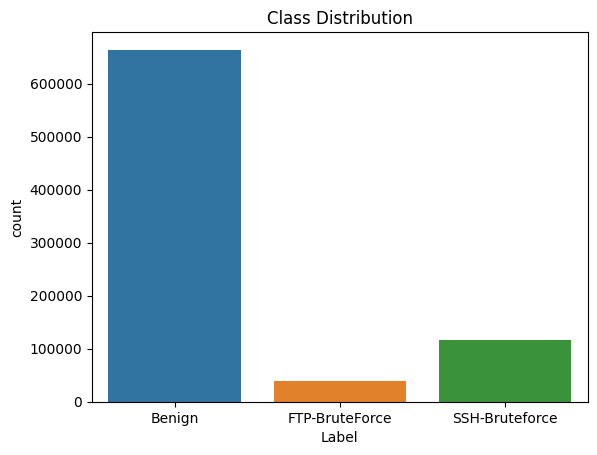

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'label' is the column containing class labels
sns.countplot(x='Label', data=data)
plt.title('Class Distribution')
plt.show()


In [ ]:
import pandas as pd

# Assuming 'label' is the column containing class labels
class_distribution = data['Label'].value_counts()

# Get the number of instances for each class
majority_class_instances = class_distribution.max()
minority_class_instances = class_distribution.min()

# Calculate the imbalance ratio
imbalance_ratio = majority_class_instances / minority_class_instances

print("Number of Majority Class Instances:", majority_class_instances)
print("Number of Minority Class Instances:", minority_class_instances)
print("Imbalance Ratio:", imbalance_ratio)


Number of Majority Class Instances: 664002
Number of Minority Class Instances: 39346
Imbalance Ratio: 16.875972144563615


In [ ]:
features = data.drop('Label', axis=1)  # Assuming 'label' is the column with class labels
labels = data['Label']

# Group by 'label' and calculate statistics for all columns
class_statistics = features.groupby(labels).describe()

# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the statistical summary
print(class_statistics)

                Dst Port                                                       \
                   count         mean           std   min   25%   50%     75%   
Label                                                                           
Benign          664002.0  7514.397924  17369.663361   0.0  53.0  80.0  3389.0   
FTP-BruteForce   39346.0    21.000000      0.000000  21.0  21.0  21.0    21.0   
SSH-Bruteforce  117322.0    21.999940      0.007724  21.0  22.0  22.0    22.0   

                         Protocol                                           \
                    max     count      mean       std  min  25%  50%   75%   
Label                                                                        
Benign          65533.0  664002.0  9.327448  5.230215  0.0  6.0  6.0  17.0   
FTP-BruteForce     21.0   39346.0  6.000000  0.000000  6.0  6.0  6.0   6.0   
SSH-Bruteforce     22.0  117322.0  6.000000  0.000000  6.0  6.0  6.0   6.0   

                     Flow Duration          

In [ ]:
# Sort each subset separately
data = data.sort_values(by=['Hour', 'Minute', 'Second'])
#considering whole data
train_percentage = 0.8

# Calculate the index to split the data
split_index = int(len(data) * train_percentage)

# Split the data into training and testing sets
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Display the shapes of the training and testing sets
print("Training set shape:", train_data.shape)
print("Testing set shape:", test_data.shape)

Training set shape: (656536, 83)
Testing set shape: (164134, 83)


In [ ]:
# Assuming 'label' is the column containing class labels
class_distribution = train_data['Label'].value_counts()

print(class_distribution)

Benign            518870
SSH-Bruteforce    117322
FTP-BruteForce     20344
Name: Label, dtype: int64


In [ ]:
# Assuming 'label' is the column containing class labels
class_distribution = test_data['Label'].value_counts()

print(class_distribution)

Benign            145132
FTP-BruteForce     19002
Name: Label, dtype: int64
